##  Trabajo 01: Optimización heurística

Equipo 04 Integrantes:

- Alejandro Bedoya Taborda

- Fredy Alberto Orozco Loaiza

- Alejandro Noriega Soto

- Ronald Gabriel Palencia

- Cristian Camilo Henao Rojas

In [32]:
import pandas as pd
import numpy as np
import pygad
import math
import random
from PIL import Image
import os
import imageio
from IPython import display

from typing import Dict, List
from collections import defaultdict
from itertools import combinations, permutations
import matplotlib.pyplot as plt
from matplotlib import animation, rc
from IPython.display import HTML;
import warnings


rc('animation', html='html5');

SEED = 42
def fix_seed(seed):
    np.random.seed(seed)
    random.seed(seed)

fix_seed(SEED)

## **Parte 1: optimización numérica**
Considere las siguientes funciones de prueba:
  * Función de Rosenbrock
  * Función de Rastrigin
  * Función de Schwefel.
  * Función de Griewank
  * Función Goldstein-Price
  * Función de las seis jorobas de camello ()

1. Escoja dos funciones de prueba 
2. Optimice las funciones en dos y tres dimensiones usando un método de descenso por gradiente con condición inicial aleatoria
3. Optimice las funciones en dos y tres dimensiones usando: algoritmos evolutivos, optimización de partículas y evolución diferencial
4. Represente con un gif animado o un video el proceso de optimización de descenso por gradiente y el proceso usando el método heurístico.



## 1. Funciones de Prueba

La funciones de prueba escogidas para probar los métodos de optimización serán las siguientes:

* Función de Rastrigin
* Función de Schwefel

Función de Schwefel

$f(x_{1},x_{2}) = \sum_{i=1}^{2} x_{i} * \sin(\sqrt{|x_{i}|}), x_{i} \in [-500,500], i = 1,2 $

Función de Rastrigin

$f(x_{1},x_{2}) = 20 + \sum_{i=1}^{2} x_{i}^{2} -10\cos(2\pi x_{i}), x_{i} \in [-5.12,5.12], i= 1,2$

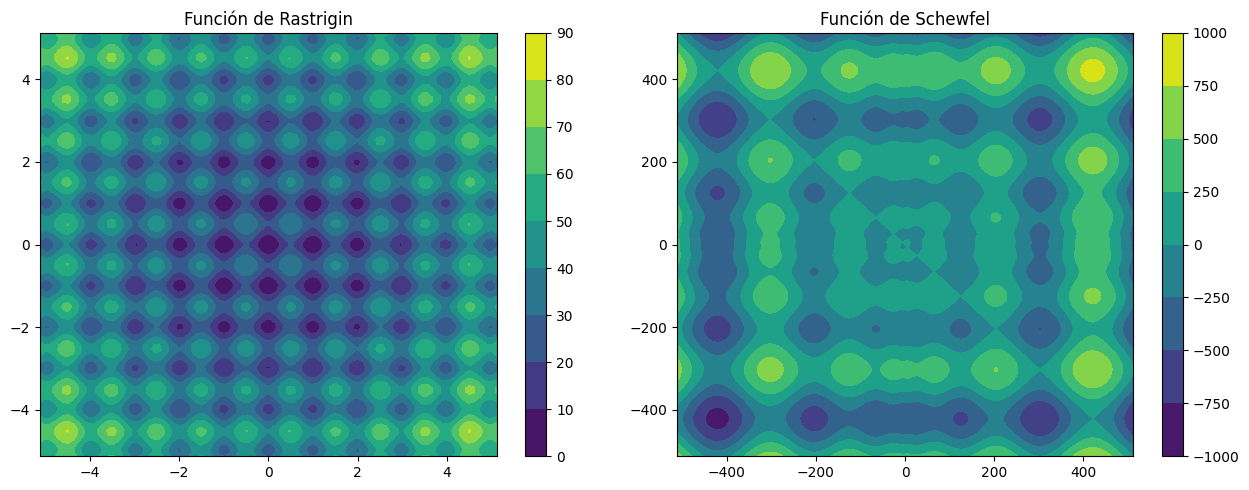

In [2]:
# Se implementa la función de Rastrigin vectorizada para arreglos numpy
def Rastrigin(X):
  Y = 10 * len(X) + np.sum(X ** 2 - 10 * np.cos(2 * np.pi * X))
  return Y
# Se implementa la función de Schwefel vectorizada para arreglos numpy
def Schwefel(X):
    Y = np.sum(X * np.sin(np.sqrt(np.abs(X))))
    return(Y)

# Visualización de la función de Rastrigin en 2D
ncols = 100
nrows = 100
X1 = np.linspace(-5.12, 5.12, ncols)     
Y1 = np.linspace(-5.12, 5.12, nrows)     
X1, Y1 = np.meshgrid(X1, Y1)

Z1 = [Rastrigin(np.array([X1[i,j], Y1[i,j]])) for i in range(nrows) for j in range(ncols)]
Z1 = np.array(Z1).reshape([nrows,ncols])

fig, (ax1,ax2) = plt.subplots(1,2)
fig.set_size_inches(13,5)
contorno = ax1.contourf(X1,Y1,Z1)
ax1.set_title("Función de Rastrigin")
fig.colorbar(contorno, ax=ax1)
fig.subplots_adjust(wspace=1.5)

# Visualización de la función de Schwefel en 2D
X2 = np.linspace(-512, 512, ncols*10)     
Y2 = np.linspace(-512, 512, nrows*10)     
X2, Y2 = np.meshgrid(X2, Y2)
Z2 = [Schwefel(np.array([X2[i,j], Y2[i,j]])) for i in range(nrows*10) for j in range(ncols*10)]
Z2 = np.array(Z2).reshape([nrows*10,ncols*10])
contorno2 = ax2.contourf(X2,Y2,Z2)
fig.colorbar(contorno2, ax=ax2)
ax2.set_title("Función de Schewfel")


plt.tight_layout()
plt.show()

## 2. Optimización mediante descenso por gradiente

### **- Implementación de funciones para optimizar**

A continuación se implementan las funciones para hallar el gradiente y la función pra optimizar mediante descenso por gradiente

In [3]:
# La siguiente función implementa el cálculo del gradiente usando 'list comprehension'
def num_grad(x, fun, h=0.01):
    return np.array([(fun(x+e*h) - fun(x-e*h)) / (2*h) for e in np.eye(len(x))])

# La siguiente función implmenta la optimización mediante descenso por gradiente
def optimizador_mult_numdev(f, x0, eta=0.01, tol=1e-6, max_iter=1e3):
    x = np.array(x0)
    iter = 0
    while np.linalg.norm(num_grad(x, f, h=0.01)) > tol and iter < max_iter:
        x = x - eta*num_grad(x, f, h=0.01)
        iter += 1
    return x

### 2.1 Función de Rastrigin

#### Generación del gráfico

Se procede a definir las características del gráfico que representará todo.

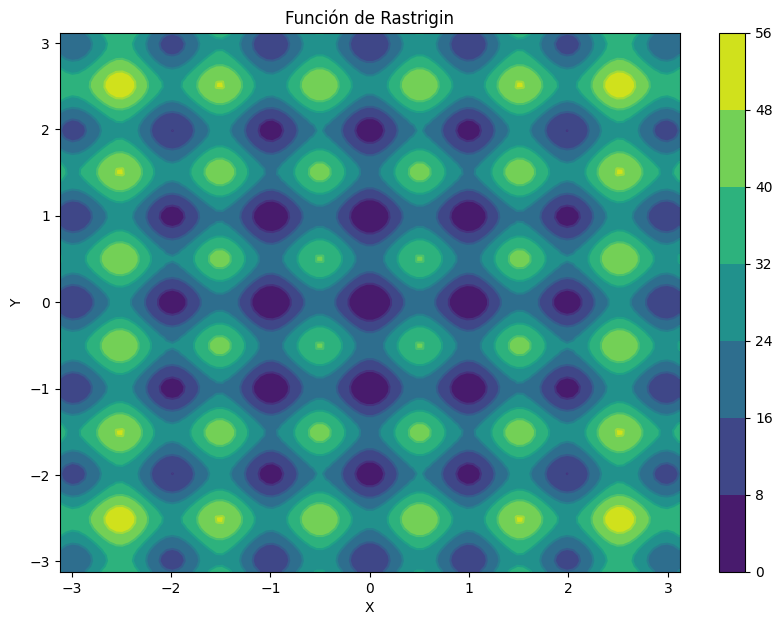

In [4]:
# Particionamiento del rango de cada variable
ncols = 100
nrows = 100
X = np.linspace(-3.12, 3.12, ncols)  #Posibles valores de X
Y = np.linspace(-3.12, 3.12, nrows)  #Posibles valores de Y
X, Y = np.meshgrid(X, Y)  #Definición del plano con posibles valores

# Evaluación de la función de Rastrigin
Z = [Rastrigin(np.array([X[i,j], Y[i,j]])) for i in range(nrows) for j in range(ncols)]
Z = np.array(Z).reshape([nrows,ncols])

fig, ax = plt.subplots()
fig.set_size_inches(10,7)
contorno = ax.contour(X,Y,Z)  #Curvas de nivel de la función de Rastrigin
contornof = ax.contourf(X,Y,Z) #Rellenando las curvas de nivel
line, = ax.plot([], [], 'xr--',mec='b') #Creando la línea que contendrá los puntos
              # de la animación de Optimización
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_title('Función de Rastrigin')
plt.colorbar(contornof) # Se muestra la barra lateral con la escala de valores
          # ¡¡Éste método depende de la creación de un objeto "contourf" !!
plt.show()

Aquí optimizamos para hallar el mínimo de la función, y de paso animamos los datos en el gráfico anteriormente elaborado

In [5]:
# Implementación del método de descenso por gradiente
x0 = np.array([4*np.random.random()-1,4*np.random.random()-1])
xs = [x0]
for i in range(25):
    x_new = optimizador_mult_numdev(Rastrigin, x0)
    xs.append(x_new)
    x0 = x_new

# Definición de la función graficadora
def graficar(frame):
    x, y = zip(*xs[:frame+1])
    line.set_data(x, y)
    return line,

# Animación final
ani = animation.FuncAnimation(fig, graficar, frames=len(xs), interval=300)
HTML(ani.to_html5_video())

### 2.2 Función de Schwefel

Con las funciones de derivadas parciales y de optimización ya implementadas, sólo resta recalcular los datos para la función de Schwefel y generar el gráfico.

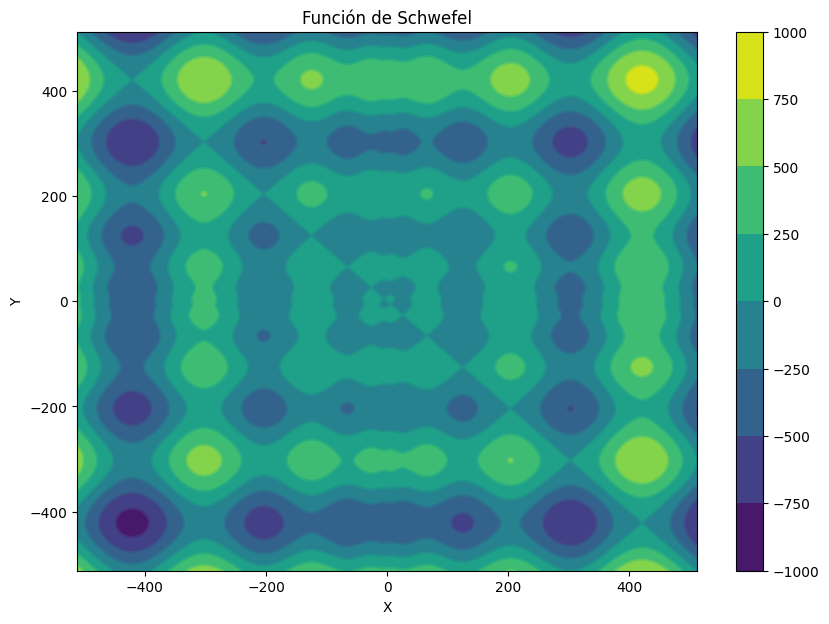

In [6]:
# Particionamiento del rango de cada variable
ncols = 1000
nrows = 1000
X = np.linspace(-512, 512, ncols)  #Posibles valores de X
Y = np.linspace(-512, 512, nrows)  #Posibles valores de Y
X, Y = np.meshgrid(X, Y)  #Definición del plano con posibles valores

# Evaluación de la función de Rastrigin
Z = [Schwefel(np.array([X[i,j], Y[i,j]])) for i in range(nrows) for j in range(ncols)]
Z = np.array(Z).reshape([nrows,ncols])

fig, ax = plt.subplots()
fig.set_size_inches(10,7)
contorno = ax.contour(X,Y,Z)  #Curvas de nivel de la función de Rastrigin
contornof = ax.contourf(X,Y,Z) #Rellenando las curvas de nivel
line, = ax.plot([], [], 'xr--',mec='b') #Creando la línea que contendrá los puntos
              # de la animación de Optimización
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_title('Función de Schwefel')
plt.colorbar(contornof) # Se muestra la barra lateral con la escala de valores
          # ¡¡Éste método depende de la creación de un objeto "contourf" !!
plt.show()

Ahora optimizamos y animamos los resultados en el gráfico anteriormente elaborado

In [7]:
# Implementación del método de descenso por gradiente
x0 = np.array([300*(2*np.random.random()-1),300*(2*np.random.random()-1)]) # generación de un punto aleatorio
xs = [x0]
for i in range(25):
    x_new = optimizador_mult_numdev(Schwefel, x0)
    xs.append(x_new)
    x0 = x_new

# Definición de la función graficadora
def graficar(frame):
    x, y = zip(*xs[:frame+1])
    line.set_data(x, y)
    return line,

# Animación final
ani = animation.FuncAnimation(fig, graficar, frames=len(xs), interval=300)
HTML(ani.to_html5_video())

## 3. Optimización mediante algoritmos evolutivos

### **- Modificación de las funciones de prueba iniciales**

Aquí modificamos las definiciones de las funciones de prueba para que se ajusten a nuestro algoritmo evolutivo

In [8]:
# Se implementa la función de Rastrigin vectorizada para arreglos numpy
def Rastrigin_ga(X,solutionidx):
  Y = 10 * len(X) + np.sum(X ** 2 - 10 * np.cos(2 * np.pi * X))
  fitness = -Y
  return (fitness)

# Se implementa la función de Schwefel vectorizada para arreglos numpy
def Schwefel_ga(X,solutionidx):
    Y = np.sum(X * np.sin(np.sqrt(np.abs(X))))
    fitness = -Y
    return(fitness)

### 3.1 Función de Rastrigin

#### - Optimización de la función de Rastrigin

Aquí se crea una instancia de nuestro algoritmo genético usando pygad para optimizar la función de Rastrigin.

Especificaciones de los parámetros:

* Se usa un número de generaciones de 60
* Se emparejan 2 individuos en cada generación
* La función de ajuste será nuestra función de prueba
* Se tomarán 9 individuos en cada generación
* El criterio de selección de reproducción : mejores individuos
* Tipo de mutación: Aleatoria

In [34]:
ga_instance_rastrigin = pygad.GA(num_generations=60,
                       num_parents_mating=2,
                       fitness_func=Rastrigin_ga,
                       sol_per_pop=9,
                       num_genes=2,
                       init_range_low=-5,
                       init_range_high=4,
                       parent_selection_type="sss",
                       keep_parents=1,
                       crossover_type="single_point",
                       mutation_type="random",
                       mutation_percent_genes=10,
                       save_solutions=True)
                       
warnings.filterwarnings("ignore")

Una vez creada la instancia de nuestro algoritmo, ejecutamos la optimización mediante el algoritmo evolutivo y mostramos la evolución del ajuste generación tras generación

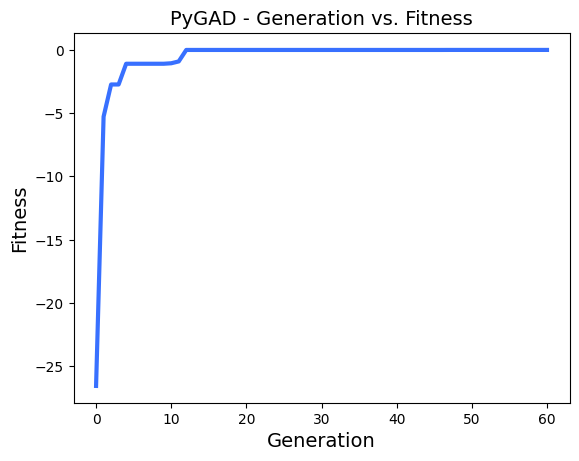

In [10]:
ga_instance_rastrigin.run()
soluciones_rastrigin = ga_instance_rastrigin.solutions
ga_instance_rastrigin.plot_fitness()
plt.show()


#### - Muestra de gráficos

Generamos un gráfico nuevamente para nuestra función de prueba

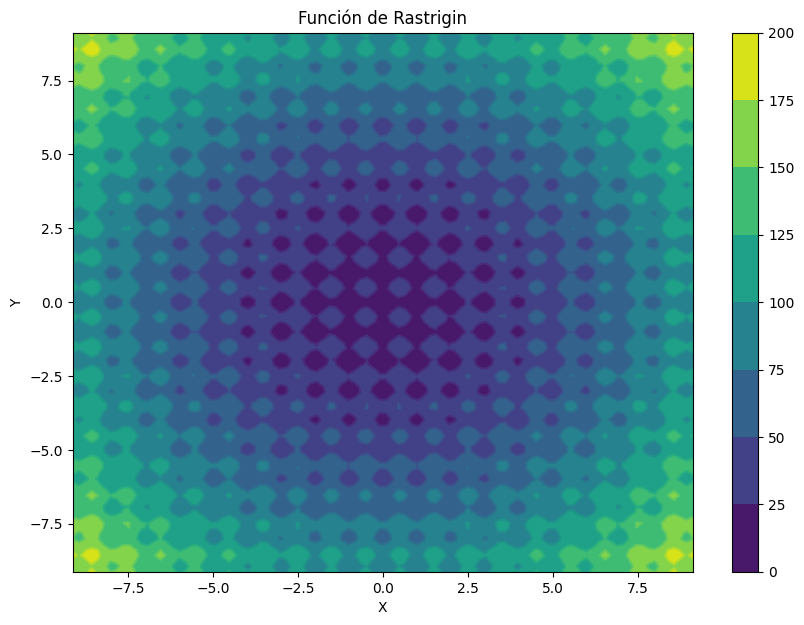

In [11]:
# Particionamiento del rango de cada variable
ncols = 100
nrows = 100
X = np.linspace(-9.12, 9.12, ncols)  #Posibles valores de X
Y = np.linspace(-9.12, 9.12, nrows)  #Posibles valores de Y
X, Y = np.meshgrid(X, Y)  #Definición del plano con posibles valores

# Evaluación de la función de Rastrigin
Z = [-Rastrigin_ga(np.array([X[i,j], Y[i,j]]),1) for i in range(nrows) for j in range(ncols)]
Z = np.array(Z).reshape([nrows,ncols])

fig, ax = plt.subplots()
fig.set_size_inches(10,7)
contorno = ax.contour(X,Y,Z)  #Curvas de nivel de la función de Rastrigin
contornof = ax.contourf(X,Y,Z) #Rellenando las curvas de nivel
line, = ax.plot([], [], 'xr--',mec='b') #Creando la línea que contendrá los puntos
              # de la animación de Optimización
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_title('Función de Rastrigin')
plt.colorbar(contornof) # Se muestra la barra lateral con la escala de valores
          # ¡¡Éste método depende de la creación de un objeto "contourf" !!
plt.show()

Y animamos los resultados obtenidos después de aplicar el algoritmo evolutivo

In [12]:
# Definición de la función graficadora
def graficar(frame):
    x, y = zip(*soluciones_rastrigin[:frame+1])
    line.set_data(x, y)
    return line,

# Animación final
ani = animation.FuncAnimation(fig, graficar, frames=len(xs), interval=300)
ani

generation vs fitness.

El punto de inflexión está sobre -1 y 0 por lo que se entiende que sería el optimo.

Funcion de Rastrigin.

En la animación del gráfico se nota que esta función mediante la optimización de algoritmos
evolutivos es fácil saber un minimo global, el cual tiende a ser la mitad o el punto 

### 3.2 Función de Schwefel

#### - Optimización de la función de Schwefel

Aquí se crea una instancia de nuestro algoritmo genético usando pygad para optimizar la función de Schwefel.

Especificaciones de los parámetros:

* Se usa un número de generaciones de 60
* Se emparejan 2 individuos en cada generación
* La función de ajuste será nuestra función de prueba
* Se tomarán 9 individuos en cada generación
* El criterio de selección de reproducción : mejores individuos
* Tipo de mutación: Aleatoria

In [36]:
ga_instance_schwefel = pygad.GA(num_generations=60,
                       num_parents_mating=2,
                       fitness_func=Schwefel_ga,
                       sol_per_pop=9,
                       num_genes=2,
                       init_range_low=-500,
                       init_range_high=500,
                       parent_selection_type="sss",
                       keep_parents=1,
                       crossover_type="single_point",
                       mutation_type="random",
                       mutation_percent_genes=10,
                       save_solutions=True)
warnings.filterwarnings("ignore")

Una vez creada la instancia de nuestro algoritmo, en este caso para Schwefel, ejecutamos la optimización mediante el algoritmo evolutivo y mostramos la evolución del ajuste generación tras generación

[[247.60938017625108, 2.7203900924791355], [-267.7873048531827, 399.5745732745685], [-116.10877862678859, 43.55286111398857], [406.4721109645469, 124.23799591399211], [-383.1019592916359, 439.8321236134751], [127.70805307141791, -165.09438534291388], [-360.72792733661277, 294.025189270296], [120.07275592851352, 33.46109197632154], [393.8925830509577, 288.5972112245307], [-360.72792733661277, 294.025189270296], [-360.72792733661277, -166.02732047344233], [-360.5881479668701, 294.025189270296], [127.70805307141791, -164.5694679714325], [-360.72792733661277, 294.7787205438195], [127.70805307141791, -165.41022184548206], [-360.08541272726876, 294.025189270296], [127.70805307141791, -165.87312186900346], [-360.72792733661277, 294.718093853765], [-360.72792733661277, 294.7787205438195], [-360.72792733661277, 294.1765966442303], [-360.28342219982665, 294.7787205438195], [-360.72792733661277, 295.1581669268572], [-360.4456320708422, 294.7787205438195], [-360.34003044767854, 294.718093853765], 

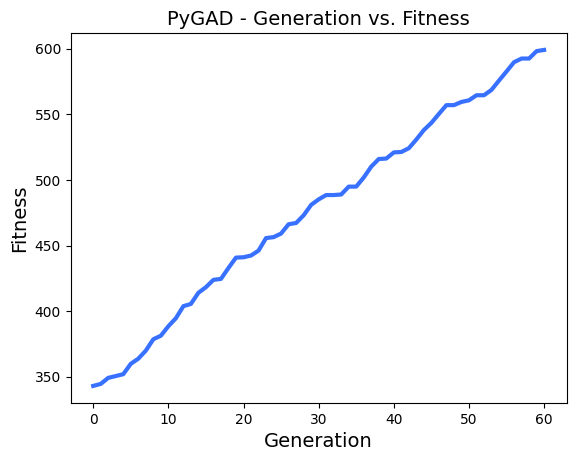

In [14]:
ga_instance_schwefel.run()
soluciones_schwefel = ga_instance_schwefel.solutions
print(soluciones_schwefel)
ga_instance_schwefel.plot_fitness()
plt.show()


#### - Muestra de gráficos

Generamos un gráfico nuevamente para nuestra función de prueba

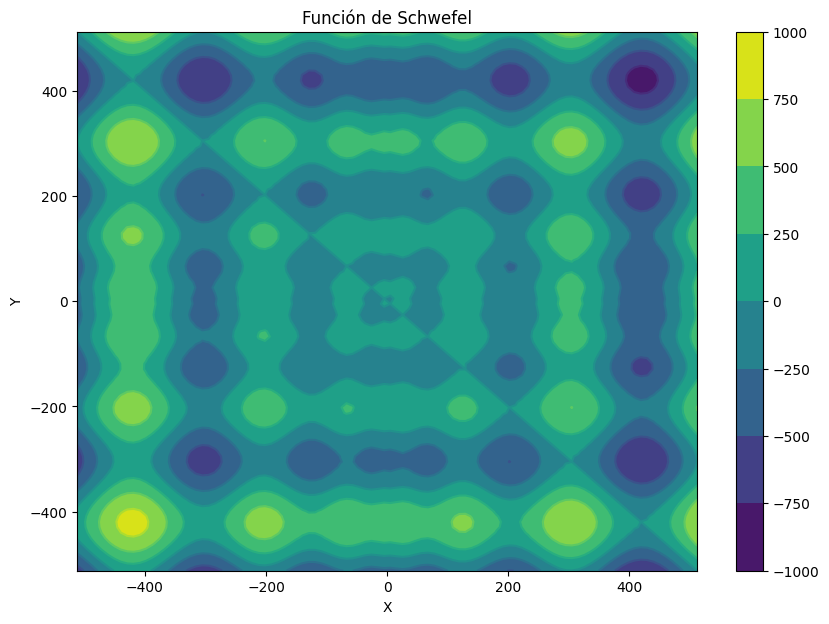

In [15]:
# Particionamiento del rango de cada variable
ncols = 100
nrows = 100
X = np.linspace(-512, 512, ncols)  #Posibles valores de X
Y = np.linspace(-512, 512, nrows)  #Posibles valores de Y
X, Y = np.meshgrid(X, Y)  #Definición del plano con posibles valores

# Evaluación de la función de Rastrigin
Z = [Schwefel_ga(np.array([X[i,j], Y[i,j]]),1) for i in range(nrows) for j in range(ncols)]
Z = np.array(Z).reshape([nrows,ncols])

fig, ax = plt.subplots()
fig.set_size_inches(10,7)
contorno = ax.contour(X,Y,Z)  #Curvas de nivel de la función de Rastrigin
contornof = ax.contourf(X,Y,Z) #Rellenando las curvas de nivel
line, = ax.plot([], [], 'xr--',mec='b') #Creando la línea que contendrá los puntos
              # de la animación de Optimización
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_title('Función de Schwefel')
plt.colorbar(contornof) # Se muestra la barra lateral con la escala de valores
          # ¡¡Éste método depende de la creación de un objeto "contourf" !!
plt.show()

Y animamos los resultados obtenidos después de aplicar el algoritmo evolutivo

In [16]:
# Definición de la función graficadora
def graficar(frame):
    x, y = zip(*soluciones_schwefel[:frame+1])
    line.set_data(x, y)
    return line,

# Animación final
ani = animation.FuncAnimation(fig, graficar, frames=len(xs), interval=300)
ani

Generation vs Fitness

No se observa ningún punto de inflexión significativo por lo que es dificil sabe qué es lo
optimo.

Funcion de Schwefel.

En la animación del gráfico se nota que esta función mediante la optimización de algoritmos
evolutivos es dificl saber un minimo global y hay poca presencia de minimos locales, de los
cuales es dificil escoger el mejor.

Con los resultados obtenidos anteriormente podemos concluir que el **Método de Descenso por Gradiente** es una buena alternativa para optimizar funciones, sin embargo, por la naturaleza del método, no se puede asegurar la convergencia al mínimo global de la función, dicha aseveración es agravada cuando en el ejercicio se escoge un punto al azar en el dominio de la función, no obstante, el método garantiza la convergencia al menos a un mínimo local.

Por otra parte, cuando se usa el algoritmo genético hay una mayor probabilidad de converger al mínimo global, no obstante, usar dicho método requiere de un ajuste mucho más minucioso en los parámetros para asegurar ésta convergencia, lo que deja planteado el interrogante sobre ¿Cómo ajustar los parámetros del algoritmo de manera óptima para cumplir el objetivo?

# El problema del viajero

## Introducción

Para solucionar el problema del viajero, lo priemero es saber cuanto va a consumir el vehiculo y el precio del galon de gasolina. Para eso usamos el siguiente vehiculo 

In [17]:
class Colombia:
    consume = 110 # Toyota Corolla hybrid has a consume of 110 km/galon 
    galon_price = 10623 # Precio en Medellín para año 2023 dado por El Espectador
    def __init__(self, data_path: str = "datos.txt", cities=None) -> None:
        default_dict = lambda: defaultdict(list, {})
        self.cities: Dict[str, Dict[str, List[int]]] = defaultdict(default_dict)
        self.data_path = data_path

    def new_conexion(
        self,
        departure: str,
        arrival: str,
        distance: int,
        price: int,
    ):
        self.cities[departure][arrival] = round(price + (distance/self.consume) * self.galon_price, 2)

    def upload_data(self):
        data = open(self.data_path, "r")
        data.readline()
        for line in data:
            line_split = line.rstrip("\n").split(";")
            list_values = [
                float(line_split[3].split()[0].replace(".","").replace(",", ".")),
                int(line_split[-1].split()[-1].replace(".", "")),
            ]
            self.new_conexion(line_split[0], line_split[1], *list_values)



En esté ejemplo, podemos ver cual es el costo para cada ciudad.

In [18]:
aux = Colombia()
aux.upload_data()
print(aux.cities["medellin"])

defaultdict(<class 'list'>, {'palmira': 108235.95, 'pasto': 253682.17, 'tulua': 82882.71, 'bogota': 102470.83, 'pereira': 62225.44, 'armenia': 93074.64, 'manizales': 48676.85, 'valledupar': 174946.68, 'monteria': 119118.81, 'soledad': 178114.62, 'cartagena': 191020.25, 'barranquilla': 198080.35, 'bucaramanga': 111070.22, 'cucuta': 146815.61})


In [19]:
cities = aux.cities.keys()
cities

dict_keys(['palmira', 'pasto', 'tulua', 'bogota', 'pereira', 'armenia', 'manizales', 'valledupar', 'monteria', 'soledad', 'cartagena', 'barranquilla', 'medellin', 'bucaramanga', 'cucuta'])

In [20]:
translate_cities = {i:v for i,v in enumerate(cities)}
translate_cities

{0: 'palmira',
 1: 'pasto',
 2: 'tulua',
 3: 'bogota',
 4: 'pereira',
 5: 'armenia',
 6: 'manizales',
 7: 'valledupar',
 8: 'monteria',
 9: 'soledad',
 10: 'cartagena',
 11: 'barranquilla',
 12: 'medellin',
 13: 'bucaramanga',
 14: 'cucuta'}

In [21]:
cost_matrix = [[0 for i in range(15)] for j in range(15)]
for i in range(15):
    for j in range(15):
        if i == j:
            cost_matrix[i][j] = 0
        else:
            cost_matrix[i][j] = aux.cities[translate_cities[i]][translate_cities[j]]

En este matriz, podemos el precio a ir a cada ciudad.

In [68]:
dist_matrix = np.array(cost_matrix)
pd.DataFrame(dist_matrix, columns = translate_cities.values())

palmira      pasto      tulua     bogota    pereira    armenia  \
0        0.00   85325.66   35148.56  109298.85   68335.11   63834.50   
1    85325.66       0.00  101192.61  196972.50   56495.05  129897.86   
2    25391.87  100999.46       0.00  179062.75   33495.58   49366.00   
3    43361.15  208831.37  107831.91       0.00  114669.00   78836.94   
4    68528.25  134398.47   33495.58   96137.55       0.00   18952.00   
5    54348.21  129801.29   28821.14   77774.64   18865.09       0.00   
6    98780.88  106427.11   73427.65   68902.66   40376.30   59154.47   
7   277212.86  316679.65  242083.62  197728.55  195570.90  196237.24   
8   248137.62  314007.84  200911.80  249382.17  204354.53  199903.73   
9   333070.75  390237.54  298038.07  235089.86  252828.78  242591.69   
10  311335.64  321305.85  276206.39  234501.36  267552.55  292284.61   
11  321553.61  387520.40  295320.94  243372.73  152401.02  250777.98   
12  108235.95  253682.17   82882.71  102470.83   62225.44   93074.64   
13  199932.97  265899.76  164803.73   91139.37  131694.44  132457.35   
14  233388.65  299355.44  198355.97   96297.86  223343.25  168106.16   

    manizales  valledupar   monteria    soledad  cartagena  barranquilla  \
0    98974.03   149006.42  220334.19  210836.85  311566.48     295360.46   
1    61516.83   144955.66  325494.13  375396.79  269719.56     371392.98   
2    73717.36   241166.48  212911.80  277800.75  297199.54     364107.23   
3    68806.09   185628.55  224102.74   96379.58  221918.50     231465.87   
4    40443.90   195764.05  191095.65  249994.89  259697.10     262501.36   
5    59202.76   195271.51  209941.43  242012.25  250763.44     249908.83   
6        0.00   167835.41  177353.92  236253.15  238151.94     222279.58   
7   167738.84        0.00   92615.99   77478.67   88035.34      85761.54   
8   178512.79    92809.14       0.00   73824.45   98029.47      82976.46   
9   213996.72    77285.53   99131.30       0.00   37357.88       1564.48   
10  241710.81    88614.77   98415.76   37357.88       0.00      36392.15   
11  213286.44    85664.96   75079.89    1583.79   36488.73          0.00   
12   48676.85   174946.68  119118.81  178114.62  191020.25     198080.35   
13   49058.95    95150.87  110095.65  141505.33  131440.82     149788.19   
14  137414.62    85442.42  100387.20  131796.87  121828.94     140176.31   

     medellin  bucaramanga     cucuta  
0   131725.66    195422.69  231361.23  
1   207371.89    261582.63  288138.30  
2   106372.43    272990.02  213035.41  
3   129777.68    101829.70   96587.58  
4    73166.56    131887.58  167729.55  
5    91915.76    131395.05  167140.44  
6    47421.40    103862.37  139800.91  
7   175332.97     94861.15   85345.85  
8   119311.95    110288.80  100387.20  
9   189314.62    141312.18  131603.73  
10  312096.26    131923.68  116425.51  
11  190376.92    215995.05  139983.16  
12       0.00    111070.22  146815.61  
13   74163.36         0.00   36324.83  
14   81012.18     53528.25       0.00

In [ ]:
Aquí cargamos las ciudades 

In [23]:
import geopandas as gpd
from PIL import Image

# Descarga el mapa de Colombia de la página de Natural Earth
# Aqui solamente cargamos el mapa de colombia
url = "ne_10m_admin_1_states_provinces.zip"
colombia = gpd.read_file(url)
colombia = colombia[colombia.iso_a2 == "CO"]

ciudades_df = pd.DataFrame({
    'nombre': ['Palmira', 'Pasto', 'Tuluá', 'Bogota', 'Pereira', 'Armenia', 'Manizales', 'Valledupar', 'Montería', 'Soledad', 'Cartagena', 'Barranquilla', 'Medellín', 'Bucaramanga', 'Cúcuta'],
    'long':[-76.30361, -77.28111, -76.19536, -74.08175, -75.69611, -75.68111, -75.51738, -73.25322, -75.88143, -74.76459, -75.51444, -74.78132, -75.56359, -73.1198, -72.50782],
    'lat':[3.53944, 1.21361, 4.08466, 4.60971, 4.81333, 4.53389, 5.06889, 10.46314, 8.74798, 10.91843, 10.39972, 10.96854, 6.25184, 7.12539, 7.89391]
})



def plot_colombia(ga_instance):
    """This function plotes the colombian map and the poiints of colombioa"""
    global colombia
    global ciudades_df
    global filenames
    global solution_idx

    solution = ga_instance.best_solution()[0]
    loss = ga_instance.best_solution()[1]
    print(solution)
    fig, ax = plt.subplots(figsize=(20, 20))
    colombia.plot(ax=ax, edgecolor='black', facecolor='white')
   
    #puts names and points
    for i, row in ciudades_df.iterrows():
        ax.plot(row['long'], row['lat'], 'ro', markersize=5)
        ax.text(row['long'] + 0.1, row['lat'] + 0.1, row['nombre'], fontsize=10)
    
    # Plotted the first with the last point
    first_point = solution[0]
    last_point = solution[-1]
    points = ((ciudades_df.loc[last_point]['long'], ciudades_df.loc[last_point]['lat']),
                    (ciudades_df.loc[first_point]['long'], ciudades_df.loc[first_point]['lat']))
    ax.annotate('', xy=points[-2], xytext=points[-1], 
                    arrowprops=dict(arrowstyle='->', color='blue', linewidth=2), 
                    fontsize=10)

    # plot the rest of the cities
    for i in range(len(solution)-2):
        first_point = solution[i]
        last_point = solution[i+1]
        points = ((ciudades_df.loc[last_point]['long'], ciudades_df.loc[last_point]['lat']),
                    (ciudades_df.loc[first_point]['long'], ciudades_df.loc[first_point]['lat']))
        ax.annotate('', xy=points[-2], xytext=points[-1], 
                        arrowprops=dict(arrowstyle='->', color='blue', linewidth=2), 
                        fontsize=10)
    ax.set_title(f'Simulación número {solution_idx}', fontsize=14)
    # ax.set_title("Pérdida: {:.2f}".format(loss))

    filename = f'images/{solution_idx}.png'
    filenames.append(filename)
    # save frame
    fig.savefig(filename)
    plt.close(fig)
    solution_idx += 1

# Algoritmos evolutivos

Recordemos que los  algoritmos evolutivos son una clase de algoritmos de optimización y búsqueda inspirados en la evolución biológica y la selección natural. Estos algoritmos son utilizados para resolver problemas complejos de optimización que no tienen una solución analítica o que requieren mucho tiempo de procesamiento. Para ese caso se usara para optimizar el recorrido por 15 ciudades que debe realizar un vendedor. En el siguiente se hace la impletación del algoritmo usando la libreria pygad.

In [24]:
import numpy as np
import pygad

def tour_length(tour, dist_matrix):
    tour = np.append(tour, tour[0])
    route = np.vstack((tour[:-1], tour[1:])).T
    result = np.sum(dist_matrix[route[:, 0]-1, route[:, 1]-1])
    return 1/result



def fitness_func(solution, solution_idx):
    global dist_matrix
    return tour_length(solution, dist_matrix)

def ga_perform(dist_matrix, max_iter):
    num_genes = dist_matrix.shape[0]
    

    gene_space = {"low": 0, "high":num_genes }
    sol_per_pop = 50
    mating_percent = 25
    num_parents_mating = math.ceil(sol_per_pop * mating_percent / 100)
    mutation_percent_genes = [20, 5]
    keep_percent = 5
    keep_parents = math.ceil(sol_per_pop * keep_percent / 100)
    ga_instance = pygad.GA(num_generations=max_iter, 
                           num_parents_mating=num_parents_mating,
                           fitness_func=fitness_func,
                           sol_per_pop=sol_per_pop,
                           num_genes=num_genes+1,
                           gene_type=int,
                           gene_space=gene_space,
                           parent_selection_type='rank',
                           keep_parents=keep_parents,
                           crossover_type='single_point',
                           mutation_type='adaptive',
                           mutation_percent_genes=mutation_percent_genes,
                           allow_duplicate_genes=False,
                           random_seed= SEED, 
                           callback_generation = plot_colombia)

    ga_instance.run()
    best_sol = ga_instance.best_solution()
    ga_instance.plot_fitness()
    best_fitness = ga_instance.best_solution()[1]
    return best_sol, best_fitness

## FUNCIÓN DE AJUSTE

En el siguiente código se hace la impletaciónde la gráfica de la función de ajuste vs las generaciones. De la gráfica se puede observar que a medida que aumenta las generaciones el error disminuye significativamente, como era de espera, ya que la población se adacta a la función de fittnes.

[ 8 10  9  4 14 11 12  5 13  0  3  6  2  1  7  4]
[ 8 10  9 10 14 11 12  5 13  0  3  6  2  1  7  4]
[ 0 12  9 13 10  8 14  8  7  5  4  1  3  6  2 11]
[ 0 14 10 12 10  8 11  3 13  9  4  7  2  1  6  5]
[ 0 14  4 12 10  8 11  3  1  2  5 13  6  7  0  9]
[ 0  8  9 12 10 11 14  8  7  5  3  6  2  1  4 13]
[ 0  8  9 12 10 11 14  5  1  2  3  7 13  4  6  5]
[ 0  8  9 12 11 10 12  5  1  2  3  6  4  7 14 13]
[ 0  8  9 12 10 11 14  7 13  5  4  1  3  6  2  7]
[ 0  8  9 12 10 11 14  7 13  5  4  1  3  6  2  7]
[ 0  8  9 12 10 11 14  7 13  5  4  1  3  6  2  7]
[ 0  8  9 12 10 11 14  7 13  5  4  1  3  6  2  7]
[ 0  8  9 12 10 11 14  7 13  5  4  1  3  6  2  7]
[ 0  8  9 12 10 11 14  7 13  5  4  1  3  6  2  7]
[ 0  8  9 12 10 11 14  7  5 13  4  6  3  1  2  7]
[ 0  8  9 12 10 11 14  7  5 13  4  6  3  1  2  7]
[ 0  8  9 12 10 11 14  7  5 13  4  6  3  1  2  7]
[ 0  8  9 12 10 11 14  7  5 13  4  6  3  1  2  7]
[ 0  8  9 12 10 11 14  7  5 13  4  6  3  1  2  7]
[ 0  8  9 12 10 11 14  7  4 13  5  6  3  1  2  7]


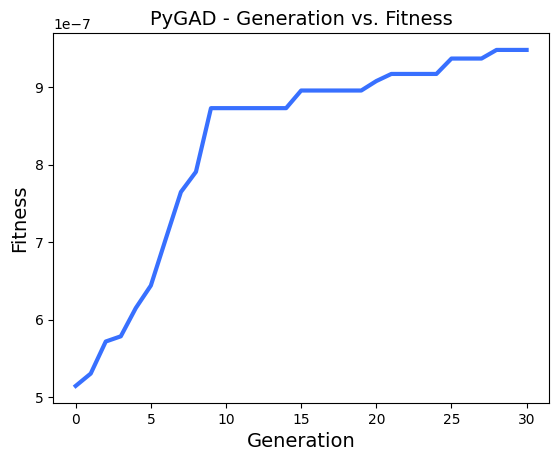

In [37]:
filenames = []
solution_idx = 0
salida= ga_perform(dist_matrix,30)
warnings.filterwarnings("ignore")

# Implementación del gif

En el siguiente código se realiza la implemetación del gif, donde podran observar la el diespligue de las diferentes rutas que el algoritmo itera hasta encontrar la ruta mas optima. 

In [26]:
import glob

# set the directory path where you want to find the PNG files
directory_path = 'images'

def numerical_sort_key(file_path):
    filename = file_path.split('/')[-1]  # get the file name from the path
    number = filename.split('.')[0]  # extract the numerical part
    return int(number)  # convert to integer and return

# use glob to find all PNG files in the directory
png_files = glob.glob(directory_path + '/*.png')
sorted_png_files = sorted(png_files, key=numerical_sort_key)
images = []
from PIL import Image
# Guardar cada imagen en la lista como un objeto de imagen
for filename in filenames:
    image = Image.open(filename)
    images.append(image)
imageio.mimsave('ruta.gif', images, duration=0.5)

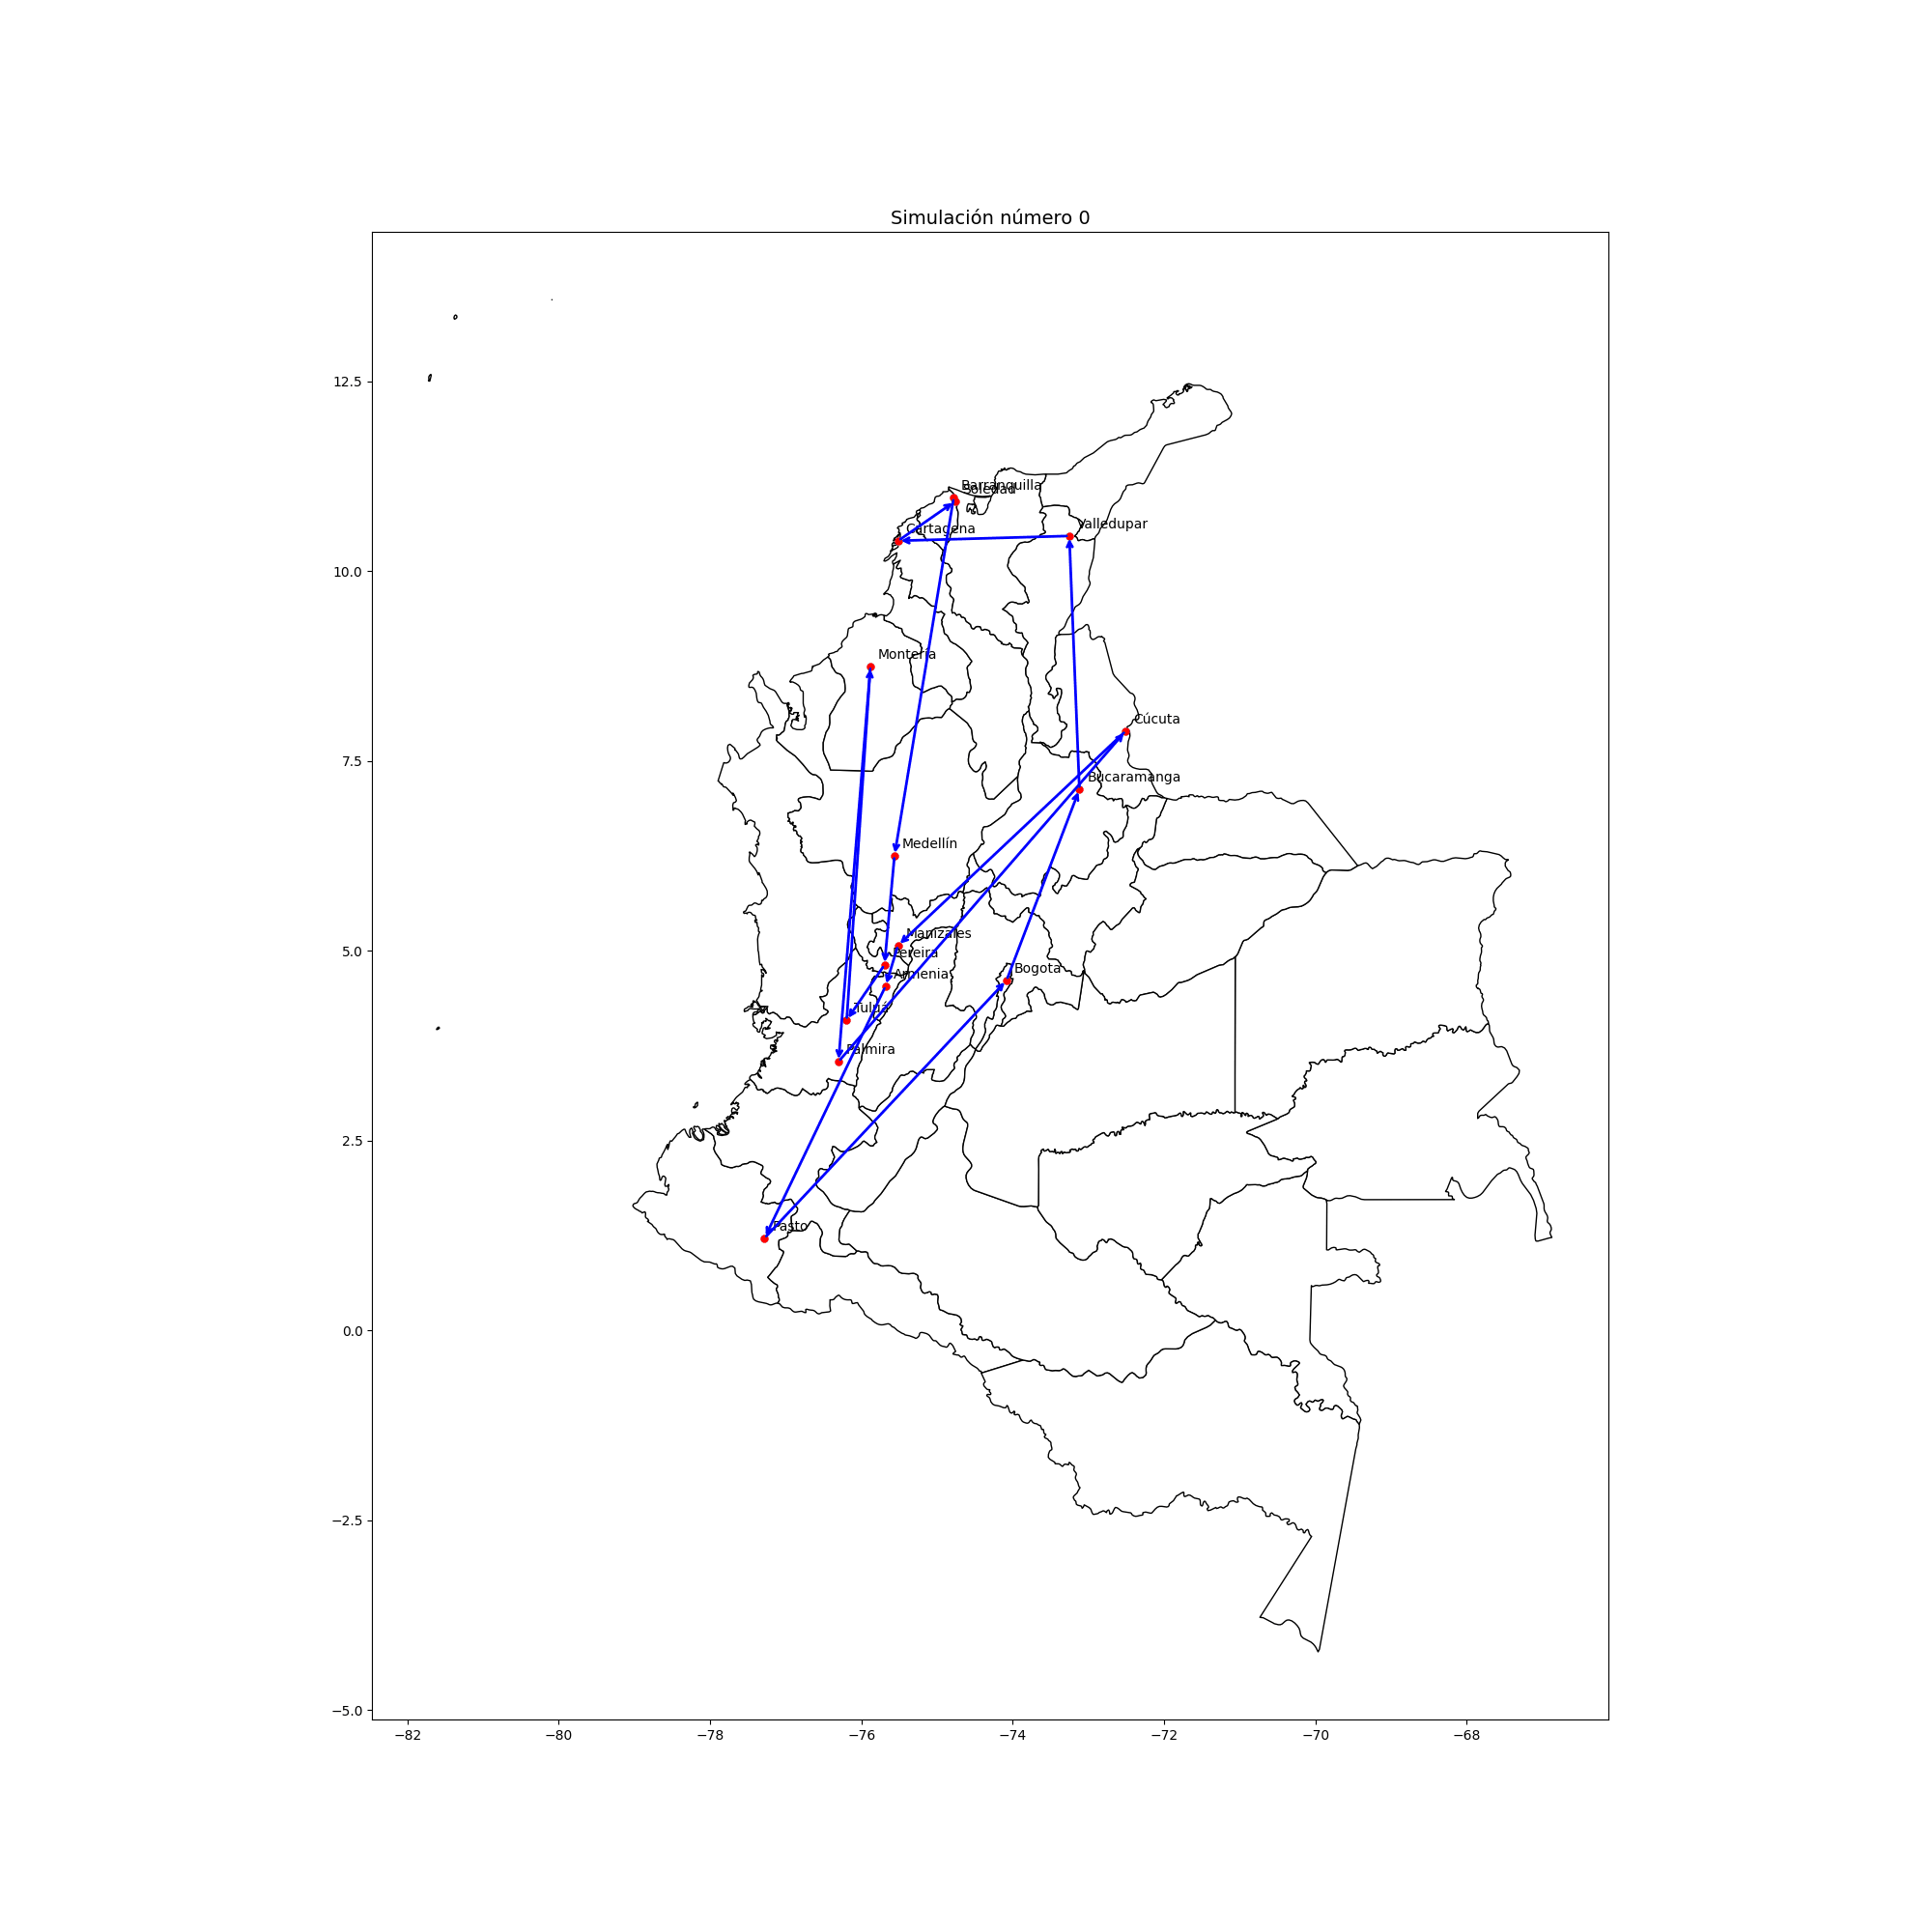

In [27]:
# Mostrar el GIF en el notebook
with open('ruta.gif','rb') as f:
    display.display(display.Image(data=f.read(), format='png'))

Finalmente podemos obervar las ciudades que presentan las ruta más optima donde su costo optimizado 1055018.4, es decir el costo optimizado es 1055018 pesos Colombianos.

In [48]:
print(f"El precio total: {1/salida[1]}")

El precio total: 1055018.4300000002


In [42]:
ciudades_df.loc[salida[0][0]]

nombre      long       lat
0        Palmira -76.30361   3.53944
8       Montería -75.88143   8.74798
11  Barranquilla -74.78132  10.96854
12      Medellín -75.56359   6.25184
10     Cartagena -75.51444  10.39972
9        Soledad -74.76459  10.91843
14        Cúcuta -72.50782   7.89391
13   Bucaramanga -73.11980   7.12539
4        Pereira -75.69611   4.81333
6      Manizales -75.51738   5.06889
5        Armenia -75.68111   4.53389
6      Manizales -75.51738   5.06889
3         Bogota -74.08175   4.60971
1          Pasto -77.28111   1.21361
2          Tuluá -76.19536   4.08466
7     Valledupar -73.25322  10.46314

# Colonia de Hormigas

Los algoritmos de colonias de hormigas (Ant Colony Optimization en inglés) son una clase de algoritmos de optimización y búsqueda inspirados en el comportamiento de las colonias de hormigas. Estos algoritmos son utilizados para resolver problemas de optimización combinatoria, como el problema del viajante de comercio, la asignación de tareas y la planificación de rutas.

Para este caso vemos la impletación de la optimización  de la ruta más corta del recorrido que hace un vendedor por 15 ciudades.  

In [29]:
import random as rn
import numpy as np
from numpy.random import choice as np_choice
from PIL import Image

class AntColony(object):

    def __init__(self, distances, cities_df, colombia, n_ants, n_best, n_iterations, decay, alpha=1, beta=1):
        """
        Args:
            distances (2D numpy.array): Square matrix of distances. Diagonal is assumed to be np.inf.
            n_ants (int): Number of ants running per iteration
            n_best (int): Number of best ants who deposit pheromone
            n_iteration (int): Number of iterations
            decay (float): Rate it which pheromone decays. The pheromone value is multiplied by decay, so 0.95 will lead to decay, 0.5 to much faster decay.
            alpha (int or float): exponenet on pheromone, higher alpha gives pheromone more weight. Default=1
            beta (int or float): exponent on distance, higher beta give distance more weight. Default=1
        Example:
            ant_colony = AntColony(german_distances, 100, 20, 2000, 0.95, alpha=1, beta=2)          
        """
        self.distances  = distances
        self.cities_df = cities_df
        self.colombia = colombia
        self.pheromone = np.ones(self.distances.shape) / len(distances)
        self.all_inds = range(len(distances))
        self.n_ants = n_ants
        self.n_best = n_best
        self.n_iterations = n_iterations
        self.decay = decay
        self.alpha = alpha
        self.beta = beta

    def plots_images(self,shortest_path, solucion_idx):

        fig, ax = plt.subplots(figsize=(20, 20))
        self.colombia.plot(ax=ax, edgecolor='black', facecolor='white')
        #puts names and points
        for i, row in self.cities_df.iterrows():
            ax.plot(row['long'], row['lat'], 'ro', markersize=5)
            ax.text(row['long'] + 0.1, row['lat'] + 0.1, row['nombre'], fontsize=10)
        # plot the rest of the cities
        for first_point, last_point in shortest_path[0]:
            points = ((self.cities_df.loc[last_point]['long'], self.cities_df.loc[last_point]['lat']),
                        (self.cities_df.loc[first_point]['long'], self.cities_df.loc[first_point]['lat']))
            ax.annotate('', xy=points[-2], xytext=points[-1], 
                            arrowprops=dict(arrowstyle='->', color='blue', linewidth=2), 
                            fontsize=10)
        ax.set_title(f'Simulación número {solucion_idx}', fontsize=14)
        filename = f'images_2/{solucion_idx}.png'
        # save frame
        fig.savefig(filename)
        plt.close(fig)
        #plt.show()
        return filename
    
    def creates_gif(self, filenames):
        images = []
        # Guardar cada imagen en la lista como un objeto de imagen
        for filename in filenames:
            image = Image.open(filename)
            images.append(image)
            os.remove(filename)
        ruta = 'ruta_2.gif'
        imageio.mimsave(ruta, images, duration=0.4)
        return ruta


    def run(self):
        shortest_path = None
        all_time_shortest_path = ("placeholder", np.inf)
        filenames = []
        for i in range(self.n_iterations):
            all_paths = self.gen_all_paths()
            self.spread_pheronome(all_paths, self.n_best, shortest_path=shortest_path)
            shortest_path = min(all_paths, key=lambda x: x[1])
            # TODO: Put save iamges here
            if i%5 == 0:
                filename = self.plots_images(shortest_path, i)
                filenames.append(filename)
            print (shortest_path)
            if shortest_path[1] < all_time_shortest_path[1]:
                all_time_shortest_path = shortest_path            
            self.pheromone = self.pheromone * self.decay
        ruta = self.creates_gif(filenames)    
        return all_time_shortest_path, ruta

    def spread_pheronome(self, all_paths, n_best, shortest_path):
        sorted_paths = sorted(all_paths, key=lambda x: x[1])
        for path, dist in sorted_paths[:n_best]:
            for move in path:
                self.pheromone[move] += 1.0 / self.distances[move]

    def gen_path_dist(self, path):
        total_dist = 0
        for ele in path:
            total_dist += self.distances[ele]
        return total_dist

    def gen_all_paths(self):
        all_paths = []
        for i in range(self.n_ants):
            path = self.gen_path(0)
            all_paths.append((path, self.gen_path_dist(path)))
        return all_paths

    def gen_path(self, start):
        path = []
        visited = set()
        visited.add(start)
        prev = start
        for i in range(len(self.distances) - 1):
            move = self.pick_move(self.pheromone[prev], self.distances[prev], visited)
            path.append((prev, move))
            prev = move
            visited.add(move)
        path.append((prev, start)) # going back to where we started    
        return path

    def pick_move(self, pheromone, dist, visited):
        pheromone = np.copy(pheromone)
        pheromone[list(visited)] = 0

        row = pheromone ** self.alpha * (( 1.0 / dist) ** self.beta)

        norm_row = row / row.sum()
        move = np_choice(self.all_inds, 1, p=norm_row)[0]
        return move


In [30]:
import numpy as np

np.fill_diagonal(dist_matrix, np.inf)
distances = dist_matrix

ant_colony = AntColony(distances,ciudades_df,colombia,1, 1, 100, 0.95, alpha=1, beta=1)
shortest_path, ruta = ant_colony.run()
print ("shorted_path: {}".format(shortest_path))

([(0, 2), (2, 13), (13, 6), (6, 4), (4, 1), (1, 7), (7, 5), (5, 3), (3, 9), (9, 11), (11, 14), (14, 8), (8, 12), (12, 10), (10, 0)], 1910922.1)
([(0, 8), (8, 4), (4, 6), (6, 14), (14, 12), (12, 3), (3, 7), (7, 11), (11, 9), (9, 2), (2, 5), (5, 13), (13, 10), (10, 1), (1, 0)], 2078261.8699999999)
([(0, 13), (13, 6), (6, 8), (8, 11), (11, 9), (9, 14), (14, 4), (4, 10), (10, 2), (2, 5), (5, 12), (12, 3), (3, 1), (1, 7), (7, 0)], 2271998.7600000002)
([(0, 2), (2, 1), (1, 8), (8, 10), (10, 13), (13, 6), (6, 4), (4, 12), (12, 7), (7, 5), (5, 11), (11, 9), (9, 14), (14, 3), (3, 0)], 1748136.3900000001)
([(0, 10), (10, 11), (11, 9), (9, 3), (3, 13), (13, 12), (12, 6), (6, 4), (4, 7), (7, 14), (14, 1), (1, 2), (2, 8), (8, 5), (5, 0)], 1998500.1800000002)
([(0, 13), (13, 11), (11, 9), (9, 7), (7, 4), (4, 12), (12, 3), (3, 10), (10, 6), (6, 1), (1, 2), (2, 5), (5, 14), (14, 8), (8, 0)], 2031568.7799999998)
([(0, 3), (3, 6), (6, 7), (7, 9), (9, 11), (11, 10), (10, 8), (8, 2), (2, 14), (14, 5), (5,

En el siguiente código se hace el despliegue del Gif, donde se observan las diferentes iteraciones que general el algoritmo de colonias de hormigas. 

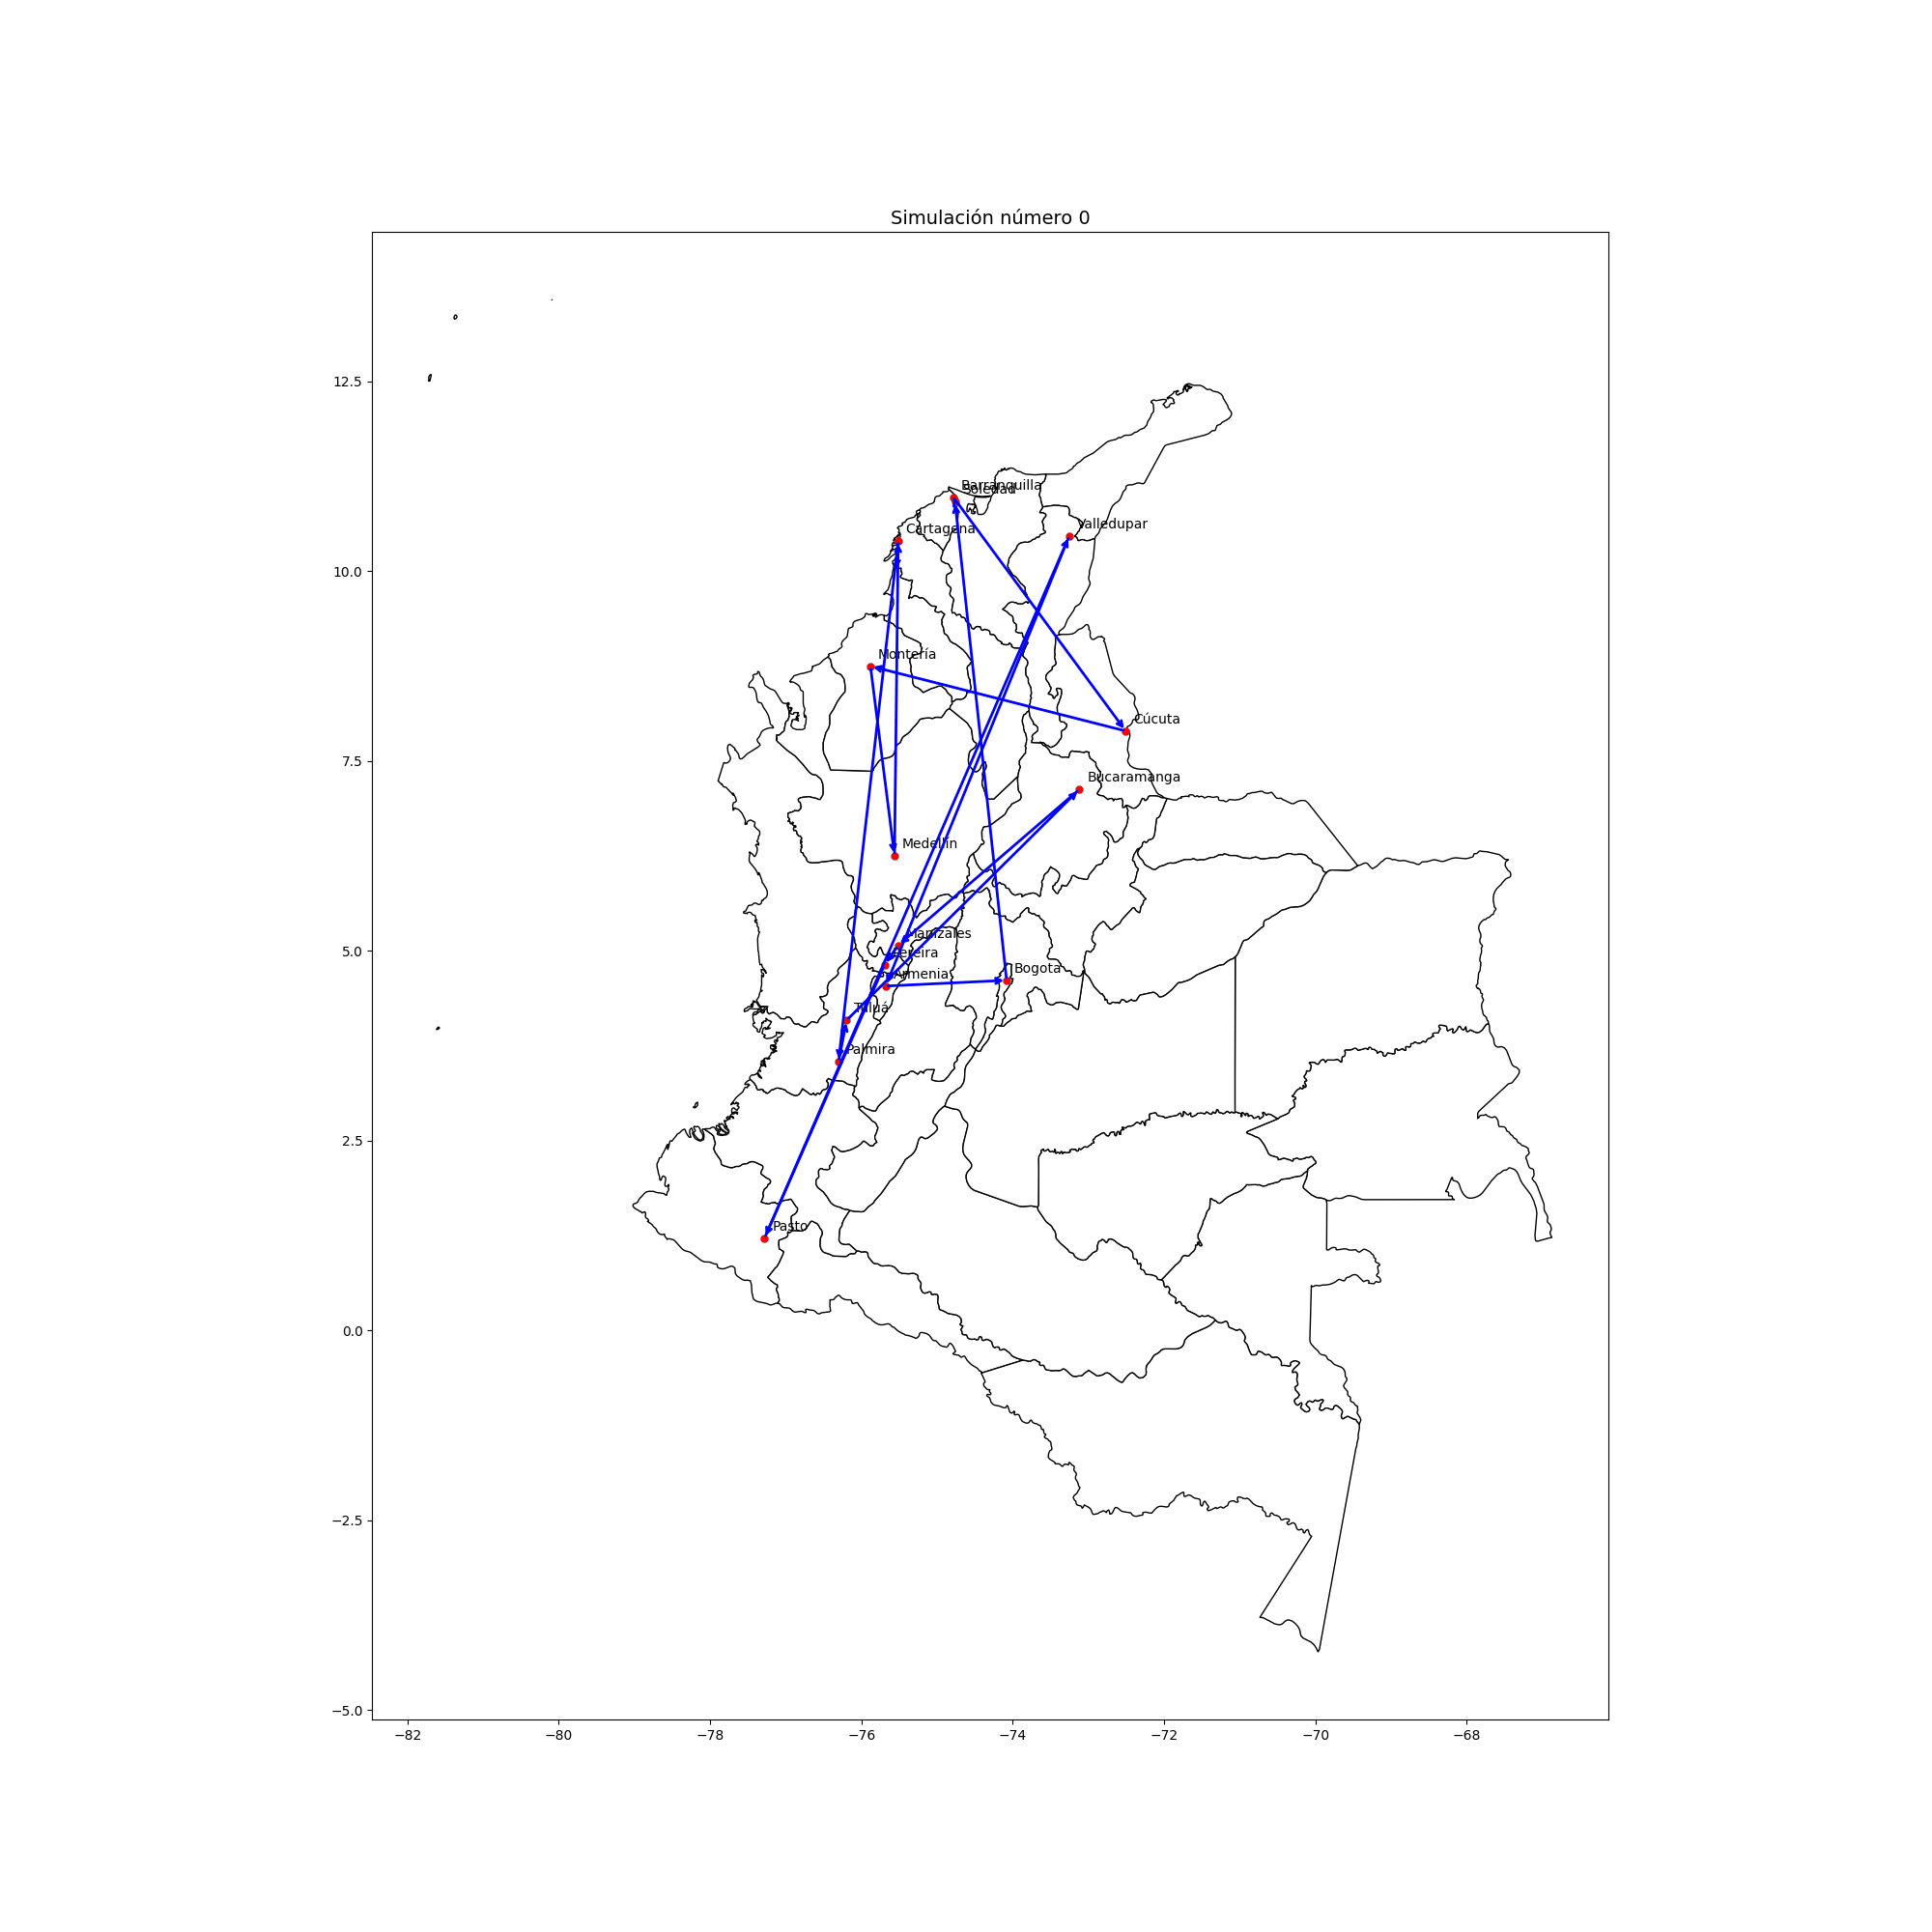

In [31]:
# Mostrar el GIF en el notebook
with open(ruta,'rb') as f:
    display.display(display.Image(data=f.read(), format='png'))

Finalmente se oberva que la ruta más optima  y que el costo optimizado es de 1069885 pesos colombianos.

In [65]:
shortest_path[1]

1069885.4000000001

In [66]:
print(f"Precios: {shortest_path[1]}")

Precios: 1069885.4000000001


In [63]:
idx = list(map(lambda x: x[0], shortest_path[0]))
ciudades_df.iloc[idx]

nombre      long       lat
0        Palmira -76.30361   3.53944
3         Bogota -74.08175   4.60971
9        Soledad -74.76459  10.91843
11  Barranquilla -74.78132  10.96854
8       Montería -75.88143   8.74798
10     Cartagena -75.51444  10.39972
14        Cúcuta -72.50782   7.89391
7     Valledupar -73.25322  10.46314
13   Bucaramanga -73.11980   7.12539
6      Manizales -75.51738   5.06889
12      Medellín -75.56359   6.25184
4        Pereira -75.69611   4.81333
5        Armenia -75.68111   4.53389
2          Tuluá -76.19536   4.08466
1          Pasto -77.28111   1.21361

### Conclusión

Finalmente logramos notar que la ruta mas optima en costos se optiene con el algoritmo evolutivo, ya que se tiene un costo de 1055018 a comparación de 1069885.

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=18f9af2f-1367-4c39-a176-9b624564f08f' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>